# Análises das features semanais

Notebook gerado automaticamente para explorar os dados de `data/features/*.parquet`. As células abaixo trazem estatísticas gerais, inspeção de valores faltantes, distribuição das classes e visões temporais de colunas-chave. Ajuste ou acrescente análises conforme necessário.

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use('ggplot')
sns.set_palette('viridis')

In [21]:
def find_project_root(marker='configs/config.yaml'):
    # Busca o diretório raiz do projeto procurando pelo arquivo marcador.
    path = Path.cwd().resolve()
    for candidate in [path, *path.parents]:
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f'Não foi possível localizar {marker} em {path} ou ancestrais.')

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data' / 'features'
CONFIG_PATH = PROJECT_ROOT / 'configs' / 'config.yaml'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

with open(CONFIG_PATH, 'r', encoding='utf-8') as fp:
    CFG = yaml.safe_load(fp)

print(f'Raiz do projeto: {PROJECT_ROOT}')
print('Arquivos disponíveis em DATA_DIR:')
for item in sorted(DATA_DIR.glob('*.parquet')):
    print(' -', item.name)

Raiz do projeto: D:\OneDrive\Documentos\Profissional\Pós IA IFG\Matérias\Trabalho Final Módulo 2\risco_deficit_energia_go
Arquivos disponíveis em DATA_DIR:
 - features_test_holdout.parquet
 - features_trainval.parquet
 - features_trainval_base.parquet
 - features_weekly.parquet


In [4]:
from src.train import rotular_semana, compute_label_thresholds


parquet_paths = {
    'trainval': DATA_DIR / 'features_trainval.parquet',
    'holdout': DATA_DIR / 'features_test_holdout.parquet',
    'weekly_full': DATA_DIR / 'features_weekly.parquet',
}

frames = {}
for name, path in parquet_paths.items():
    if path.exists():
        frames[name] = pd.read_parquet(path)
        print(f"{name}: {frames[name].shape[0]:,} linhas x {frames[name].shape[1]:,} colunas")
    else:
        print(f"[aviso] Arquivo não encontrado: {path}")

for df in frames.values():
    if isinstance(df.index, pd.DatetimeIndex):
        df.sort_index(inplace=True)

frames

trainval: 324 linhas x 1,008 colunas
holdout: 80 linhas x 1,008 colunas
weekly_full: 404 linhas x 1,008 colunas


{'trainval':                            carga_mwh_mean_w  carga_mwh_sum_w  carga_mwh_max_w  \
 data                                                                            
 2018-01-07 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-14 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-21 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-28 00:00:00+00:00               NaN              NaN              NaN   
 2018-02-04 00:00:00+00:00               NaN              NaN              NaN   
 ...                                     ...              ...              ...   
 2024-02-18 00:00:00+00:00      2.202484e+06     1.541739e+07      2363546.376   
 2024-02-25 00:00:00+00:00      2.227188e+06     1.559032e+07      2338724.903   
 2024-03-03 00:00:00+00:00      2.381197e+06     1.666838e+07      2540284.010   
 2024-03-10 00:00:00+00:00      2.324995e+06     1.627496e+07      2435583.798   
 202

## Panorama geral

In [6]:
!pip install jinja2
overview_rows = []
for name, df in frames.items():
    overview_rows.append({
        'dataset': name,
        'linhas': len(df),
        'colunas': df.shape[1],
        'inicio': df.index.min(),
        'fim': df.index.max(),
        'tipo_index': type(df.index).__name__,
    })

overview = pd.DataFrame(overview_rows)
display(overview)

for name, df in frames.items():
    numeric_stats = df.select_dtypes(include=[np.number]).describe().loc[['mean', 'std', 'min', 'max']]
    display(numeric_stats.T.head(25).style.format(precision=2).set_caption(f'Estatísticas numéricas (top 25 colunas) - {name}'))

,dataset,linhas,colunas,inicio,fim,tipo_index
0,trainval,324,1008,2018-01-07 00:00:00+00:00,2024-03-17 00:00:00+00:00,DatetimeIndex
1,holdout,80,1008,2024-03-24 00:00:00+00:00,2025-09-28 00:00:00+00:00,DatetimeIndex
2,weekly_full,404,1008,2018-01-07 00:00:00+00:00,2025-09-28 00:00:00+00:00,DatetimeIndex


,mean,std,min,max
carga_mwh_mean_w,1950643.49,148688.26,1625354.99,2429133.44
carga_mwh_sum_w,13640243.69,1074973.55,9269470.89,17003934.06
carga_mwh_max_w,2069222.67,166558.07,1687592.30,2572253.48
carga_mwh_min_w,1722452.88,136241.53,1449363.50,2231085.71
carga_mwh_std_w,124718.49,33496.90,55331.44,245284.35
carga_mwh__p95_w,2062202.04,164589.20,1685809.65,2571449.81
carga_mwh__p05_w,1766298.24,136869.03,1499655.94,2258976.87
ger_hidreletrica_mwh_mean_w,684494.86,101779.16,417890.27,902638.13
ger_hidreletrica_mwh_sum_w,4791464.00,712454.15,2925231.87,6318466.88
ger_hidreletrica_mwh_max_w,737027.03,109482.30,463013.99,973053.73


,mean,std,min,max
carga_mwh_mean_w,2118680.02,207601.05,867184.70,2556205.04
carga_mwh_sum_w,14776561.08,1818915.31,1734369.41,17893435.26
carga_mwh_max_w,2254973.19,177606.49,1734369.41,2684865.49
carga_mwh_min_w,1857010.48,252593.71,0.00,2246047.58
carga_mwh_std_w,150200.55,126763.48,80037.15,1226384.37
carga_mwh__p95_w,2247146.76,179552.25,1647650.94,2674867.14
carga_mwh__p05_w,1907227.13,248063.74,86718.47,2310955.35
ger_hidreletrica_mwh_mean_w,642487.46,116001.08,480666.57,902834.19
ger_hidreletrica_mwh_sum_w,4483379.80,826610.67,3364665.99,6319839.35
ger_hidreletrica_mwh_max_w,694556.62,126738.71,516288.70,999926.35


,mean,std,min,max
carga_mwh_mean_w,1990181.50,178969.33,867184.70,2556205.04
carga_mwh_sum_w,13907612.49,1373637.20,1734369.41,17893435.26
carga_mwh_max_w,2112928.68,186473.57,1687592.30,2684865.49
carga_mwh_min_w,1754113.50,179770.61,0.00,2246047.58
carga_mwh_std_w,130714.27,68695.87,55331.44,1226384.37
carga_mwh__p95_w,2105718.44,185424.67,1647650.94,2674867.14
carga_mwh__p05_w,1799457.98,179545.62,86718.47,2310955.35
ger_hidreletrica_mwh_mean_w,676176.56,105931.01,417890.27,902834.19
ger_hidreletrica_mwh_sum_w,4730457.23,745575.95,2925231.87,6319839.35
ger_hidreletrica_mwh_max_w,728617.04,114205.39,463013.99,999926.35


## Valores faltantes

In [8]:
def top_missing(df, top=25):
    miss = df.isna().mean().mul(100).sort_values(ascending=False).head(top)
    return miss.rename('percentual_na')

missing_tables = {}
for name, df in frames.items():
    miss = top_missing(df)
    missing_tables[name] = miss
    print(f"\n{name} - top {len(miss)} colunas com mais NA (%):")
    display(miss.to_frame())

missing_tables


trainval - top 25 colunas com mais NA (%):


,percentual_na
ens_week_ratio_lag4w,20.987654
ens_week_mwh_lag4w,20.987654
reserve_margin_ratio_w_lag4w,20.987654
margem_vs_carga_w_lag4w,20.987654
carga_mwh__p05_w_lag4w,20.987654
carga_mwh_max_w_lag4w,20.987654
carga_mwh_min_w_lag4w,20.987654
carga_mwh_sum_w_lag4w,20.987654
carga_mwh_mean_w_lag4w,20.987654
carga_mwh_std_w_lag4w,20.987654



holdout - top 25 colunas com mais NA (%):


,percentual_na
carga_mwh_mean_w,0.0
carga_mwh_sum_w,0.0
carga_mwh_max_w,0.0
carga_mwh_min_w,0.0
carga_mwh_std_w,0.0
carga_mwh__p95_w,0.0
carga_mwh__p05_w,0.0
ger_hidreletrica_mwh_mean_w,0.0
ger_hidreletrica_mwh_sum_w,0.0
ger_hidreletrica_mwh_max_w,0.0



weekly_full - top 25 colunas com mais NA (%):


,percentual_na
ens_week_ratio_lag4w,16.831683
ens_week_mwh_lag4w,16.831683
reserve_margin_ratio_w_lag4w,16.831683
margem_vs_carga_w_lag4w,16.831683
carga_mwh__p05_w_lag4w,16.831683
carga_mwh_max_w_lag4w,16.831683
carga_mwh_min_w_lag4w,16.831683
carga_mwh_sum_w_lag4w,16.831683
carga_mwh_mean_w_lag4w,16.831683
carga_mwh_std_w_lag4w,16.831683


{'trainval': ens_week_ratio_lag4w              20.987654
 ens_week_mwh_lag4w                20.987654
 reserve_margin_ratio_w_lag4w      20.987654
 margem_vs_carga_w_lag4w           20.987654
 carga_mwh__p05_w_lag4w            20.987654
 carga_mwh_max_w_lag4w             20.987654
 carga_mwh_min_w_lag4w             20.987654
 carga_mwh_sum_w_lag4w             20.987654
 carga_mwh_mean_w_lag4w            20.987654
 carga_mwh_std_w_lag4w             20.987654
 carga_mwh__p95_w_lag4w            20.987654
 carga_mwh_mean_w_lag2w            20.370370
 ens_week_mwh_lag2w                20.370370
 reserve_margin_ratio_w_lag2w      20.370370
 margem_vs_carga_w_lag2w           20.370370
 ens_week_ratio_lag2w              20.370370
 carga_mwh_std_w_lag2w             20.370370
 carga_mwh_max_w_lag2w             20.370370
 carga_mwh_sum_w_lag2w             20.370370
 carga_mwh_min_w_lag2w             20.370370
 carga_mwh__p95_w_lag2w            20.370370
 carga_mwh__p05_w_lag2w            20.37037

## Distribuição das classes (rotular_semana)

In [9]:
thresholds = compute_label_thresholds(CFG, frames['trainval'])

label_results = {}
for name, df in frames.items():
    ref_df = frames['trainval']
    labels = rotular_semana(df, CFG, ref_df=ref_df)
    labels = labels.dropna()
    label_results[name] = labels

    count = labels.value_counts().rename('contagem')
    frac = (count / count.sum()).rename('percentual')
    dist = pd.concat([count, frac.mul(100)], axis=1)
    display(dist.style.format({'percentual': '{:.2f}%'}).set_caption(f'Distribuição de classes - {name}'))

,contagem,percentual
baixo,140,53.85%
alto,92,35.38%
medio,28,10.77%


,contagem,percentual
alto,34,42.50%
baixo,31,38.75%
medio,15,18.75%


,contagem,percentual
baixo,171,50.29%
alto,126,37.06%
medio,43,12.65%


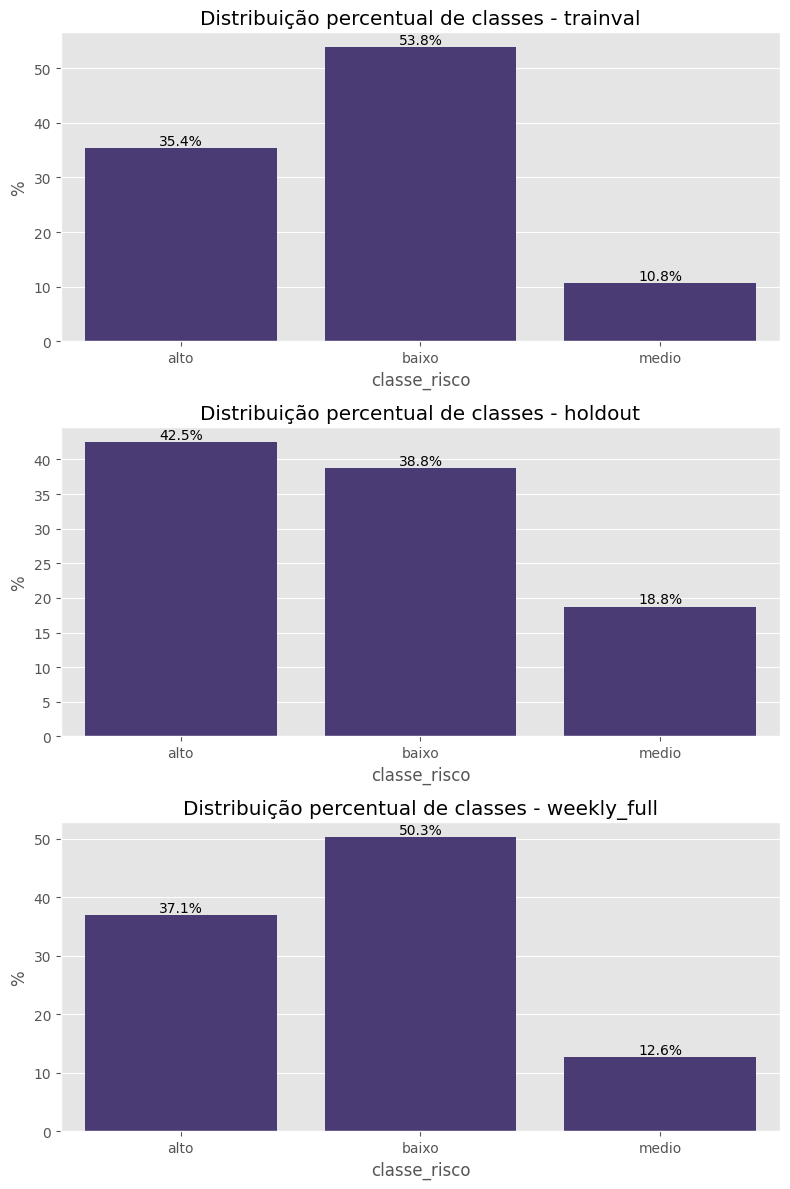

In [10]:
fig, axes = plt.subplots(len(label_results), 1, figsize=(8, 4 * len(label_results)))
if len(label_results) == 1:
    axes = [axes]

for ax, (name, labels) in zip(axes, label_results.items()):
    share = labels.value_counts(normalize=True).sort_index()
    sns.barplot(x=share.index, y=share.values * 100, ax=ax)
    ax.set_title(f'Distribuição percentual de classes - {name}')
    ax.set_ylabel('%')
    ax.set_xlabel('classe_risco')
    for x, val in enumerate(share.values * 100):
        ax.text(x, val + 0.5, f'{val:.1f}%', ha='center')
plt.tight_layout()

In [28]:
import pandas as pd
import yaml
from src.train import rotular_semana

# Carrega a configuração
cfg = yaml.safe_load(open("../../configs/config.yaml", "r", encoding="utf-8"))

# Carrega os dados de treino/validação
df_trainval = pd.read_parquet("../../data/features/features_trainval.parquet")

# Gera os rótulos para o conjunto de treino/validação
# A função 'rotular_semana' usa o próprio DataFrame como referência para os quantis
# e aplica todas as regras de ajuste (hidrologia, cortes, etc.)
labels_trainval = rotular_semana(df_trainval, cfg)

# Combina as features com os rótulos gerados
df_trainval_with_labels = df_trainval.copy()
df_trainval_with_labels['classe_risco'] = labels_trainval

# Agora você pode inspecionar semanas específicas
print("--- Amostra do Conjunto de Treino/Validação com Rótulos ---")
print(df_trainval_with_labels[['classe_risco']].tail(10)) # Mostra as últimas 10 semanas

# Exemplo: Ver semanas rotuladas como "alto"
print("\n--- Semanas com Risco Alto ---")
semanas_alto_risco = df_trainval_with_labels[df_trainval_with_labels['classe_risco'] == 'alto']
print(semanas_alto_risco.index)



--- Amostra do Conjunto de Treino/Validação com Rótulos ---
                          classe_risco
data                                  
2024-01-14 00:00:00+00:00         alto
2024-01-21 00:00:00+00:00         alto
2024-01-28 00:00:00+00:00        baixo
2024-02-04 00:00:00+00:00        medio
2024-02-11 00:00:00+00:00         alto
2024-02-18 00:00:00+00:00        medio
2024-02-25 00:00:00+00:00        medio
2024-03-03 00:00:00+00:00         alto
2024-03-10 00:00:00+00:00         alto
2024-03-17 00:00:00+00:00         alto

--- Semanas com Risco Alto ---
DatetimeIndex(['2019-08-04 00:00:00+00:00', '2019-08-11 00:00:00+00:00',
               '2019-08-18 00:00:00+00:00', '2019-08-25 00:00:00+00:00',
               '2019-09-01 00:00:00+00:00', '2019-09-08 00:00:00+00:00',
               '2019-09-15 00:00:00+00:00', '2019-09-22 00:00:00+00:00',
               '2019-09-29 00:00:00+00:00', '2019-10-06 00:00:00+00:00',
               '2019-10-13 00:00:00+00:00', '2019-10-20 00:00:00+00:00',
  

## Checagem de duplicatas no conjunto de treino

In [11]:
train_index = frames['trainval'].index
n_dup = train_index.duplicated().sum()
print(f'Total de índices duplicados em trainval: {n_dup}')
if n_dup:
    dup_counts = train_index[train_index.duplicated()].value_counts()
    display(dup_counts.head(10).to_frame('ocorrencias'))

Total de índices duplicados em trainval: 0


## Sinais principais ao longo do tempo

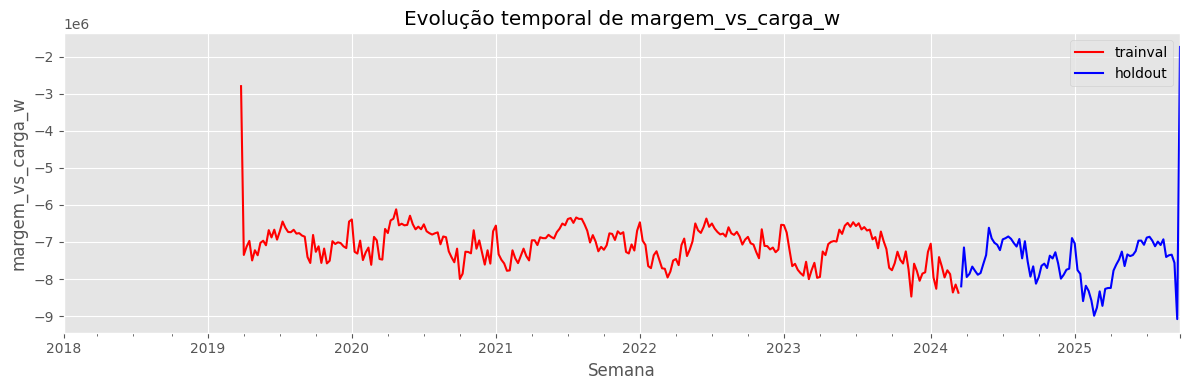

In [13]:
margem_col = CFG['problem']['label_rules'].get('coluna_margem', 'margem_vs_carga_w')

fig, ax = plt.subplots(figsize=(12, 4))
frames['trainval'][margem_col].plot(ax=ax, label='trainval',color='red')
if 'holdout' in frames:
    frames['holdout'][margem_col].plot(ax=ax, label='holdout',color='blue')
ax.set_title(f'Evolução temporal de {margem_col}')
ax.set_xlabel('Semana')
ax.set_ylabel(margem_col)
ax.legend()
plt.tight_layout()

## Correlação entre variáveis numéricas (treino)

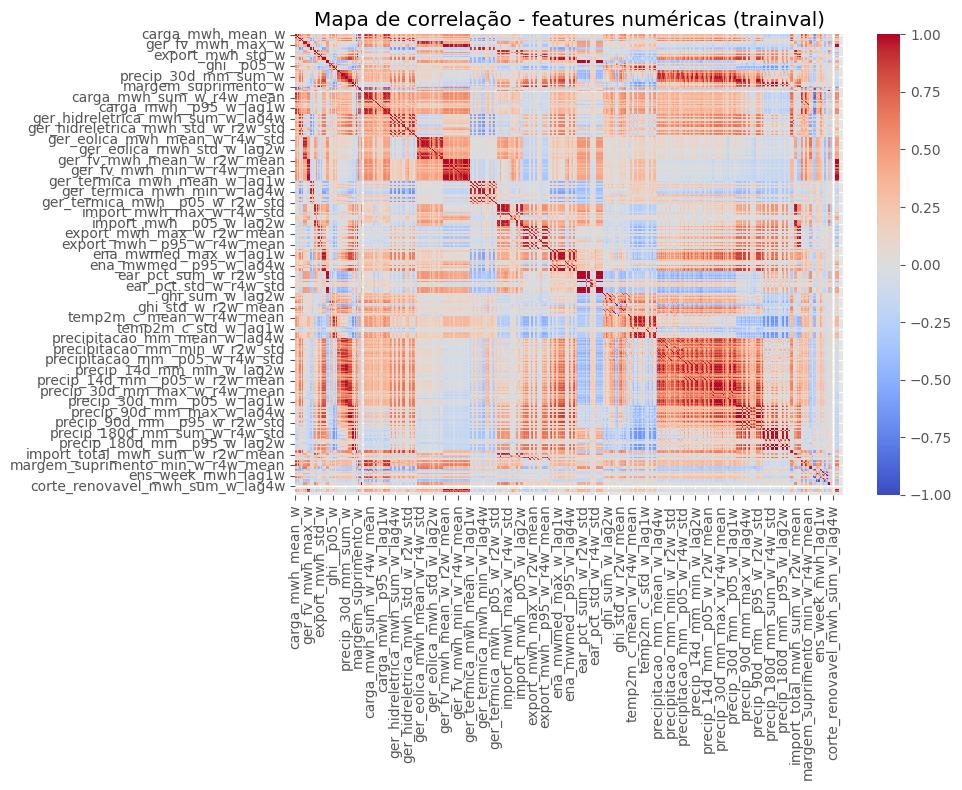

In [14]:
corr = frames['trainval'].select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Mapa de correlação - features numéricas (trainval)')
plt.tight_layout()